In [1]:
import biasgen
import numpy as np
import matplotlib.pyplot as plt

FIGSZ_DFLT = (6.4, 4.8)

# Coil Setups

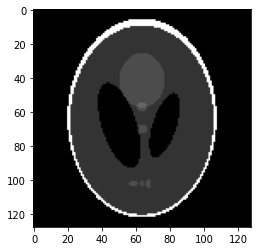

In [2]:
# generate phantom
ph = biasgen.phantom3d(n=128)

plt.imshow(ph[64], cmap='gray')
plt.show()

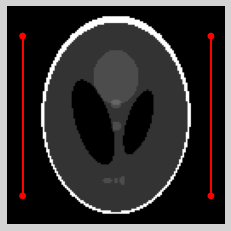

In [3]:
# construct 2 coil setup
coils = biasgen.cage_constructor(n_coils=2, center=(64,64,64), coil_height=128, 
                                 length_to_space_ratio=0.35, ellip_axes=(90,65))
biasgen.view_coil_positioning(ph, coils)

# Magnetic Field Computations

To benefit from GPU acceleration we call *use_gpu* to significantly speed up various field calculations. This function only needs to be called once during a running session.

In [4]:
## Comment out if no gpu available
biasgen.use_gpu(True)

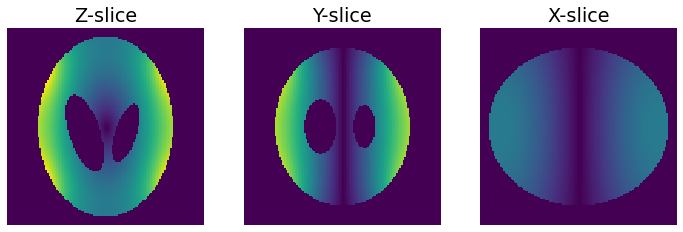

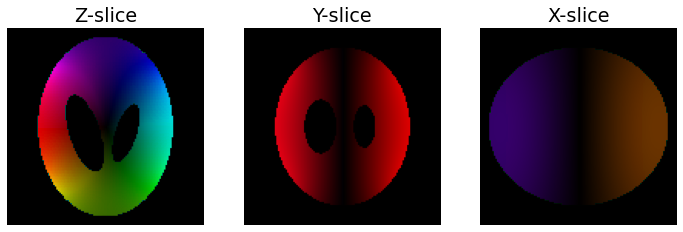

In [5]:
# generate magnetic field tensor
# arguments batch_sz and scale_fctr help for memory-limited computations
field = biasgen.compute_field(coils, ph.shape, sum_coils=True, batch_sz=1, scale_fctr=0.75)

# measure tensor with readout u and phase enconding v
uv = ((0,0,1.),(0,1.,0))
field_measured = biasgen.field_readout(field, uv)

# visualize absolute and complex information
ph_mask = ph > 0
titles = ['Z-slice', 'Y-slice', 'X-slice']
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['font.size'] = 16

biasgen.view_center_axes(np.abs(field_measured), ph_mask, titles)
biasgen.view_center_axes(field_measured, ph_mask, titles)

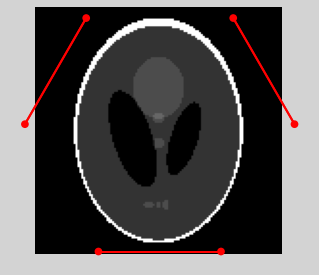

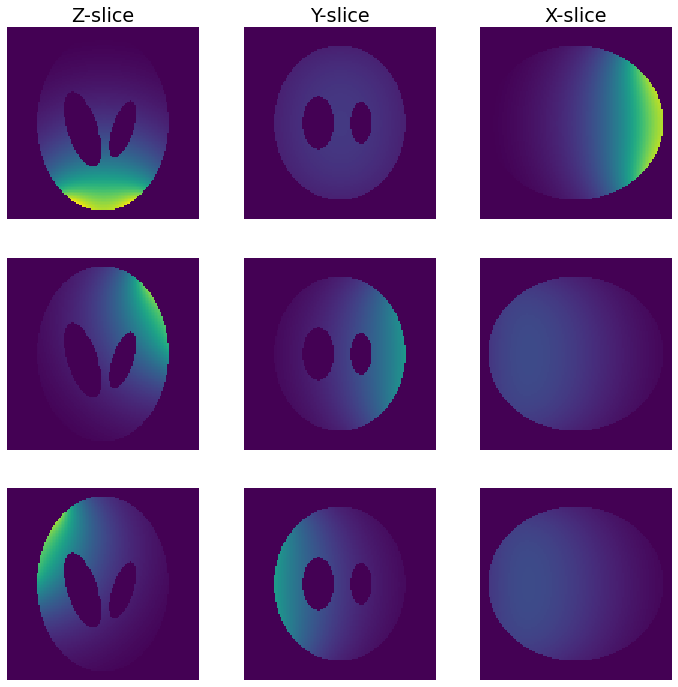

In [6]:
# we can also isolate the individual coil contributions by supressing the sum_coils argument
coils = biasgen.cage_constructor(3, (64,64,64), 128, 0.45, (70, 70), 0)
plt.rcParams['figure.figsize'] = FIGSZ_DFLT
biasgen.view_coil_positioning(ph, coils)

field = biasgen.compute_field(coils, ph.shape, batch_sz=1, scale_fctr=0.75)
field_measured = biasgen.field_readout(field, uv)

plt.rcParams['figure.figsize'] = (12,12)
biasgen.view_center_axes(np.abs(field_measured), ph_mask, titles)

# Sensitivity Map Computaions

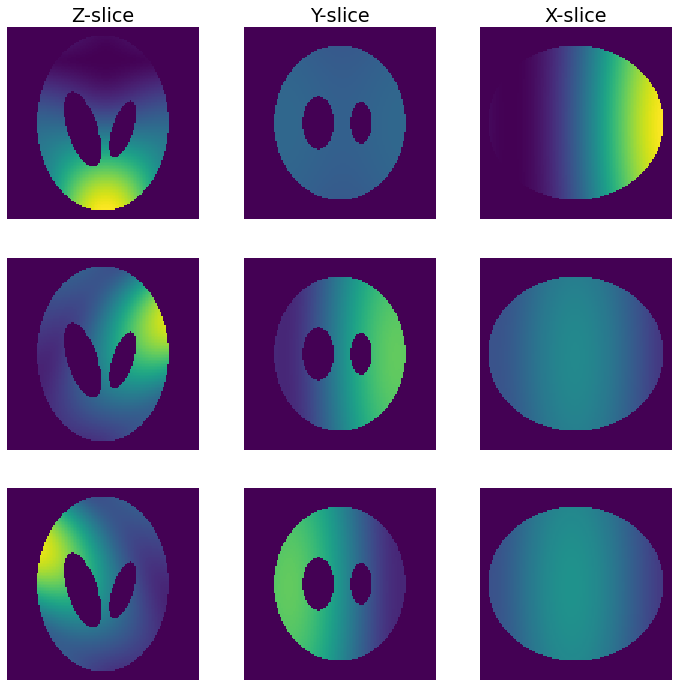

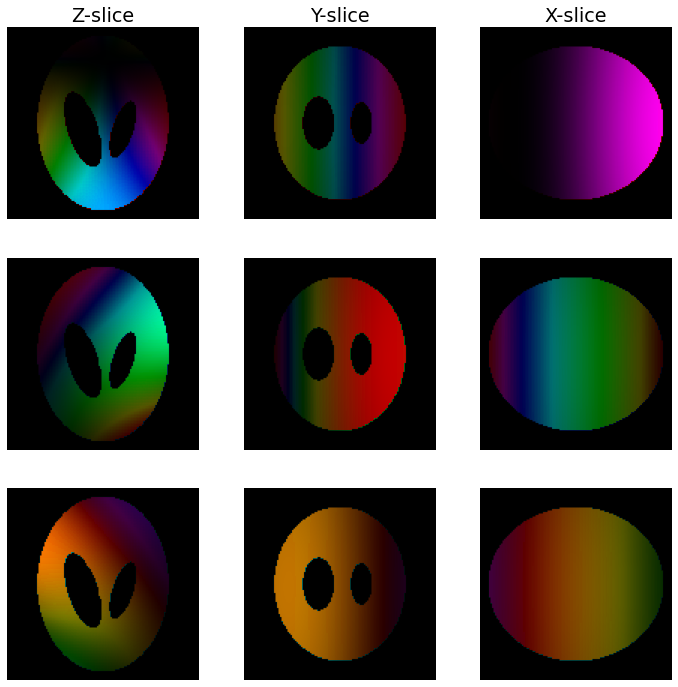

In [7]:
# next we can set up the sampling grid for our sinusoidal sensitivity model
sens_settings = biasgen.SensitivitySettings(grid_lengths=(7,7,7), grid_spacings=(0.5,1.75,1.75), 
                                            grid_shifts=(0,-0.25,-0.25))
# compute sensitivity map
sens = biasgen.compute_sensitivity(coils, sens_settings, ph.shape, batch_sz=1, scale_fctr=0.25)

# visualize absolute and complex information
biasgen.view_center_axes(np.abs(sens), ph_mask, titles)
biasgen.view_center_axes(sens, ph_mask, titles)

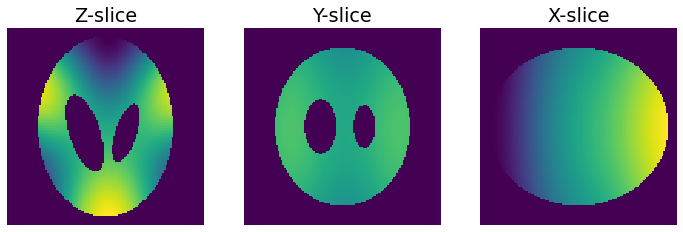

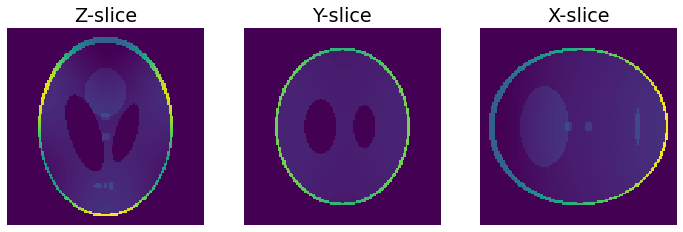

In [8]:
# we can interpret these maps as a bias field by considering a simple sum-of-squares reconstruction
bias = biasgen.bias_sum_of_squares(sens)

# bias field
biasgen.view_center_axes(bias, ph_mask, titles)

# bias field applied
biasgen.view_center_axes(bias*ph, ph_mask, titles)